In [18]:
! pip install -q kaggle

In [19]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"negarmansouri96","key":"dff6cfe0d2006e749b7c718a13c89eef"}'}

In [20]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [21]:
! chmod 600 ~/.kaggle/kaggle.json

In [22]:
! kaggle datasets download -d mkashifn/nbaiot-dataset #downloading the kaggle dataset

Dataset URL: https://www.kaggle.com/datasets/mkashifn/nbaiot-dataset
License(s): unknown
nbaiot-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [23]:
import zipfile
import os
import pandas as pd
import re

In [24]:
zip_file_path = "/content/nbaiot-dataset.zip"

In [ ]:
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('extracted_files')

In [ ]:
os.remove("/content/extracted_files/README.md")
os.remove("/content/extracted_files/data_summary.csv")
os.remove("/content/extracted_files/device_info.csv")
os.remove("/content/extracted_files/features.csv")

In [ ]:
csv_files = [f for f in os.listdir('extracted_files') if f.endswith('.csv')]

n_bootstrap_samples = 13000

bootstrapped_dfs = []

# Define a function to clean the label
def clean_label(file_name):
    return re.sub(r'^\d+\.', '', file_name)

# Iterate through each CSV file, perform sampling, clean labels, and assign binary labels
for file in csv_files:
    # Read the CSV file
    df = pd.read_csv(os.path.join('extracted_files', file))

    bootstrap_sample = df.sample(n=n_bootstrap_samples, replace=False, random_state=42)

    label = clean_label(file.replace('.csv', ''))

    bootstrap_sample['label'] = label



    bootstrapped_dfs.append(bootstrap_sample)

final_df = pd.concat(bootstrapped_dfs, ignore_index=True)

print(final_df.head())

category_counts = final_df['label'].value_counts()
print("\nCategory Counts:")
print(category_counts)

label_counts = final_df['label'].value_counts()


In [16]:
final_df.shape

(1157000, 116)

In [17]:
print(final_df.describe())

       MI_dir_L5_weight  MI_dir_L5_mean  MI_dir_L5_variance  MI_dir_L3_weight  \
count      1.157000e+06    1.157000e+06        1.157000e+06      1.157000e+06   
mean       8.267593e+01    1.496655e+02        1.109874e+04      1.303857e+02   
std        6.978007e+01    1.466430e+02        2.141066e+04      1.117528e+02   
min        1.000000e+00    6.000000e+01        0.000000e+00      1.000000e+00   
25%        1.032211e+00    6.000001e+01        2.728484e-12      1.142845e+00   
50%        8.403074e+01    7.402638e+01        1.966007e+00      1.241315e+02   
75%        1.479464e+02    1.900609e+02        5.430793e+03      2.389061e+02   
max        4.380028e+02    1.452096e+03        4.712302e+05      5.586770e+02   

       MI_dir_L3_mean  MI_dir_L3_variance  MI_dir_L1_weight  MI_dir_L1_mean  \
count    1.157000e+06        1.157000e+06      1.157000e+06    1.157000e+06   
mean     1.497768e+02        1.234093e+04      3.662275e+02    1.501464e+02   
std      1.423662e+02        2.25

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import pandas as pd
from tqdm import tqdm

features = final_df.iloc[:, :-1]
labels = final_df['label']

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

n_estimators = 100
rf = RandomForestClassifier(n_estimators=1, warm_start=True, random_state=42, n_jobs=-1)

for i in tqdm(range(1, n_estimators + 1), desc="Building Trees"):
    rf.set_params(n_estimators=i)
    rf.fit(scaled_features, labels)

importances = rf.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': features.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Select top 27 most important features
top_27_features = feature_importance_df.head(27)['Feature'].values
print("Top 27 selected features:")
print(top_27_features)

selected_features_df = final_df[top_27_features]

final_data = pd.concat([selected_features_df, labels], axis=1)

print(final_data.head())


Building Trees: 100%|██████████| 100/100 [14:38<00:00,  8.79s/it]


Top 27 selected features:
['H_L0.01_mean' 'MI_dir_L0.01_mean' 'H_L0.1_weight' 'MI_dir_L0.1_weight'
 'H_L0.01_weight' 'MI_dir_L0.01_variance' 'H_L0.01_variance' 'H_L0.1_mean'
 'MI_dir_L0.01_weight' 'MI_dir_L0.1_mean' 'H_L0.1_variance'
 'MI_dir_L0.1_variance' 'MI_dir_L1_weight' 'H_L1_mean' 'HH_jit_L1_mean'
 'HH_jit_L0.01_mean' 'H_L1_weight' 'HH_L0.01_magnitude' 'H_L3_weight'
 'MI_dir_L1_mean' 'HH_L0.1_magnitude' 'HH_L0.01_mean' 'H_L3_mean'
 'MI_dir_L3_mean' 'HH_jit_L3_weight' 'HH_jit_L5_mean' 'HH_jit_L3_mean']
   H_L0.01_mean  MI_dir_L0.01_mean  H_L0.1_weight  MI_dir_L0.1_weight  \
0     76.592440          76.592440     857.798401          857.798401   
1     76.066894          76.066894    1248.246948         1248.246948   
2     76.659268          76.659268     694.482287          694.482287   
3     76.695754          76.695754     901.941010          901.941010   
4     76.235676          76.235676    1097.885299         1097.885299   

   H_L0.01_weight  MI_dir_L0.01_variance  H_L0.

In [12]:
final_data.shape


(1157000, 28)

In [13]:
print(final_data.describe())

       H_L0.01_mean  MI_dir_L0.01_mean  H_L0.1_weight  MI_dir_L0.1_weight  \
count  1.157000e+06       1.157000e+06   1.157000e+06        1.157000e+06   
mean   1.499650e+02       1.499654e+02   3.233234e+03        3.233234e+03   
std    1.342985e+02       1.343003e+02   2.880334e+03        2.880334e+03   
min    6.000000e+01       6.000000e+01   1.000000e+00        1.000000e+00   
25%    6.010083e+01       6.010083e+01   3.701190e+00        3.701013e+00   
50%    7.435888e+01       7.435888e+01   2.898233e+03        2.898233e+03   
75%    2.356508e+02       2.356508e+02   6.318670e+03        6.318670e+03   
max    1.383197e+03       1.383197e+03   8.946924e+03        8.946924e+03   

       H_L0.01_weight  MI_dir_L0.01_variance  H_L0.01_variance   H_L0.1_mean  \
count    1.157000e+06           1.157000e+06      1.157000e+06  1.157000e+06   
mean     1.612456e+04           1.473442e+04      1.473455e+04  1.507834e+02   
std      1.653261e+04           2.376697e+04      2.376692e+04  1.

In [14]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import numpy as np

features = final_data.iloc[:, :-1]
labels = final_data['label']

scaler = MinMaxScaler(feature_range=(0, 255))
scaled_features = scaler.fit_transform(features)


kmeans = KMeans(n_clusters=9, random_state=42)
kmeans.fit(scaled_features.T)


cluster_assignments = kmeans.labels_

image_dataset = []
image_labels = []

for i in range(scaled_features.shape[0]):
    feature_row = scaled_features[i, :]

    rgb_image = np.zeros((3, 3, 3))

    for cluster_idx in range(9):
        feature_indices = np.where(cluster_assignments == cluster_idx)[0]


        for channel, feature_index in enumerate(feature_indices[:3]):
            x = cluster_idx // 3  # Row index in 3x3 grid
            y = cluster_idx % 3   # Column index in 3x3 grid
            rgb_image[x, y, channel] = feature_row[feature_index]

    image_dataset.append(rgb_image)
    image_labels.append(labels.iloc[i])

image_dataset = np.array(image_dataset)
image_labels = np.array(image_labels)

print(f"Image dataset shape: {image_dataset.shape}")
print(f"Label dataset shape: {image_labels.shape}")


Image dataset shape: (1157000, 3, 3, 3)
Label dataset shape: (1157000,)


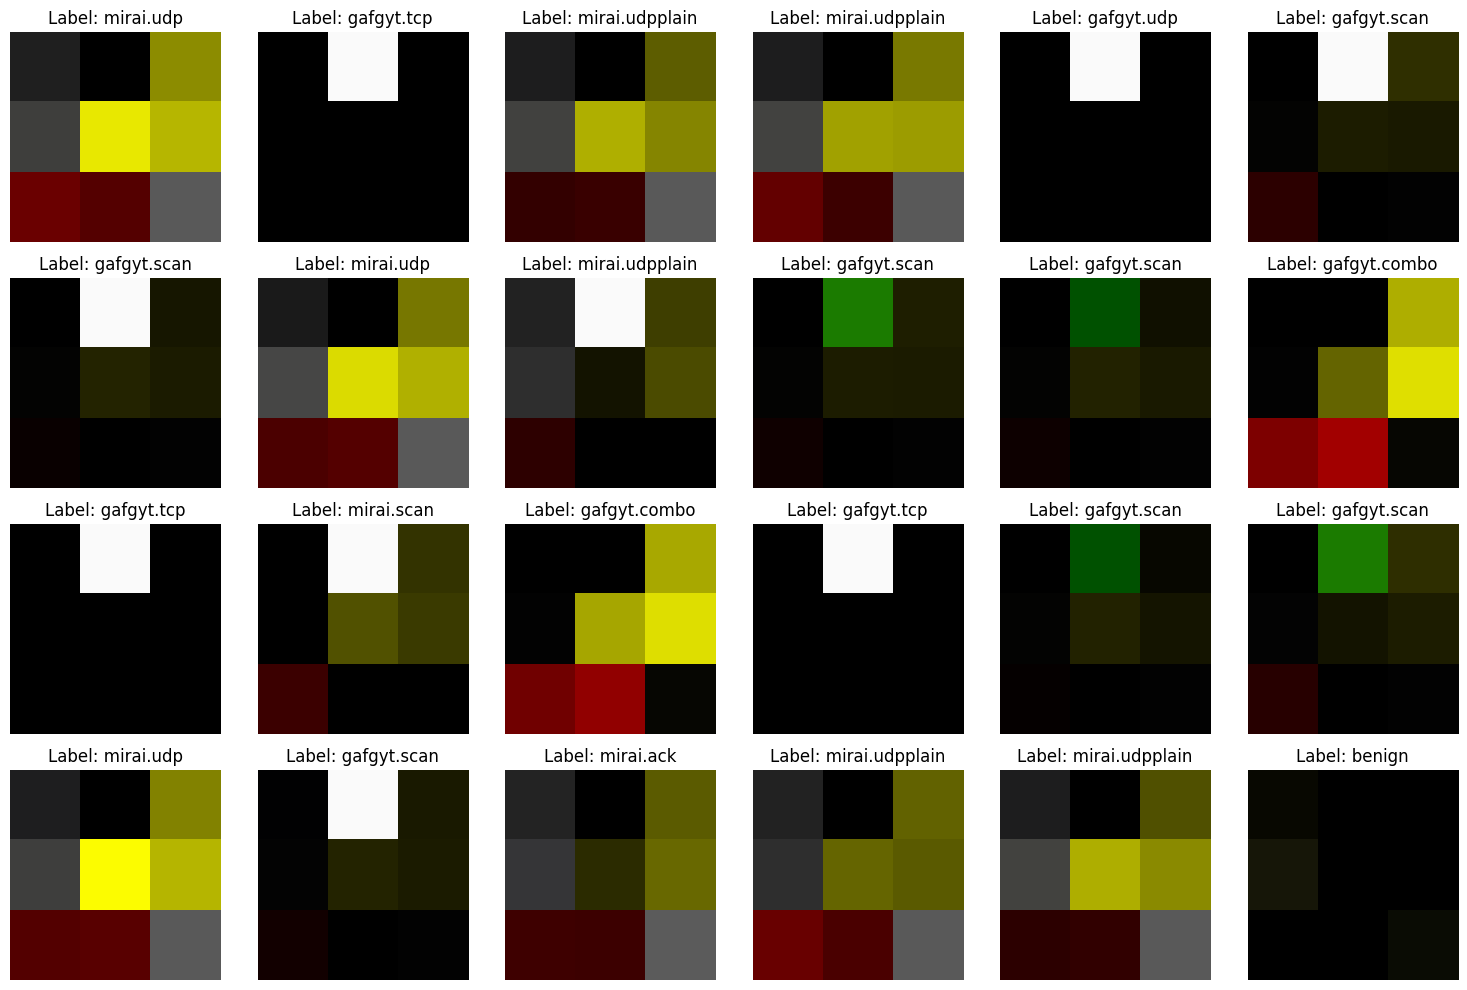

In [15]:
import matplotlib.pyplot as plt

def show_random_images(image_dataset, image_labels, num_samples=24):
    # Randomly select 'num_samples' images
    indices = np.random.choice(len(image_dataset), num_samples, replace=False)
    selected_images = image_dataset[indices]
    selected_labels = image_labels[indices]

    fig, axes = plt.subplots(4, 6, figsize=(15, 10))

    axes = axes.flatten()

    for i in range(num_samples):
        img = selected_images[i]
        label = selected_labels[i]

        axes[i].imshow(img.astype(np.uint8))
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')

    for j in range(num_samples, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

show_random_images(image_dataset, image_labels)


Using device: cuda
ImprovedMultiClassCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gap): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=128, out_features=11, bias=True)
  (relu): ReLU()
)
Number of trainable parameters: 33547


Training Epochs:   5%|▌         | 1/20 [01:07<21:29, 67.86s/it]

Epoch [1/20], Loss: 0.2844, Accuracy: 83.80%


Training Epochs:  10%|█         | 2/20 [02:14<20:04, 66.92s/it]

Epoch [2/20], Loss: 0.1894, Accuracy: 87.72%


Training Epochs:  15%|█▌        | 3/20 [03:19<18:49, 66.42s/it]

Epoch [3/20], Loss: 0.1666, Accuracy: 88.55%


Training Epochs:  20%|██        | 4/20 [04:26<17:45, 66.59s/it]

Epoch [4/20], Loss: 0.1581, Accuracy: 88.85%


Training Epochs:  25%|██▌       | 5/20 [05:33<16:37, 66.50s/it]

Epoch [5/20], Loss: 0.1533, Accuracy: 89.03%


Training Epochs:  30%|███       | 6/20 [06:36<15:17, 65.54s/it]

Epoch [6/20], Loss: 0.1492, Accuracy: 89.11%


Training Epochs:  35%|███▌      | 7/20 [07:43<14:15, 65.78s/it]

Epoch [7/20], Loss: 0.1474, Accuracy: 89.21%


Training Epochs:  40%|████      | 8/20 [08:48<13:08, 65.69s/it]

Epoch [8/20], Loss: 0.1447, Accuracy: 89.31%


Training Epochs:  45%|████▌     | 9/20 [09:54<12:04, 65.89s/it]

Epoch [9/20], Loss: 0.1432, Accuracy: 89.33%


Training Epochs:  50%|█████     | 10/20 [11:02<11:02, 66.30s/it]

Epoch [10/20], Loss: 0.1408, Accuracy: 89.38%


Training Epochs:  55%|█████▌    | 11/20 [12:08<09:56, 66.32s/it]

Epoch [11/20], Loss: 0.1389, Accuracy: 89.47%


Training Epochs:  60%|██████    | 12/20 [13:13<08:47, 65.99s/it]

Epoch [12/20], Loss: 0.1372, Accuracy: 89.53%


Training Epochs:  65%|██████▌   | 13/20 [14:19<07:42, 66.02s/it]

Epoch [13/20], Loss: 0.1359, Accuracy: 89.57%


Training Epochs:  70%|███████   | 14/20 [15:23<06:31, 65.27s/it]

Epoch [14/20], Loss: 0.1336, Accuracy: 89.66%


Training Epochs:  75%|███████▌  | 15/20 [16:29<05:27, 65.56s/it]

Epoch [15/20], Loss: 0.1323, Accuracy: 89.72%


Training Epochs:  80%|████████  | 16/20 [17:35<04:22, 65.69s/it]

Epoch [16/20], Loss: 0.1308, Accuracy: 89.74%


Training Epochs:  85%|████████▌ | 17/20 [18:40<03:16, 65.58s/it]

Epoch [17/20], Loss: 0.1299, Accuracy: 89.78%


Training Epochs:  90%|█████████ | 18/20 [19:46<02:11, 65.69s/it]

Epoch [18/20], Loss: 0.1289, Accuracy: 89.84%


Training Epochs:  95%|█████████▌| 19/20 [20:52<01:05, 65.70s/it]

Epoch [19/20], Loss: 0.1285, Accuracy: 89.82%


Training Epochs: 100%|██████████| 20/20 [21:58<00:00, 65.91s/it]

Epoch [20/20], Loss: 0.1283, Accuracy: 89.81%


Test Loss: 0.1317, Test Accuracy: 89.85%


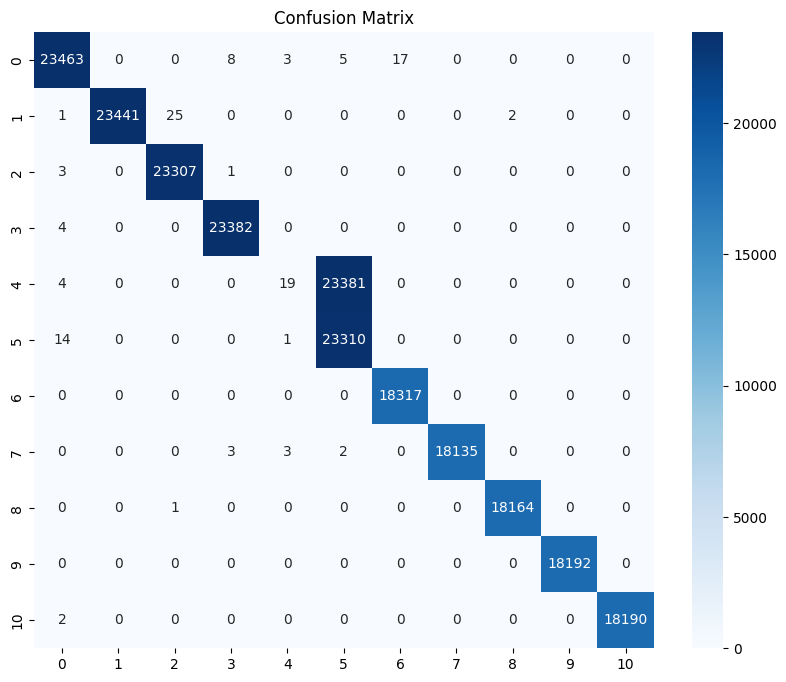

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23496
           1       1.00      1.00      1.00     23469
           2       1.00      1.00      1.00     23311
           3       1.00      1.00      1.00     23386
           4       0.73      0.00      0.00     23404
           5       0.50      1.00      0.67     23325
           6       1.00      1.00      1.00     18317
           7       1.00      1.00      1.00     18143
           8       1.00      1.00      1.00     18165
           9       1.00      1.00      1.00     18192
          10       1.00      1.00      1.00     18192

    accuracy                           0.90    231400
   macro avg       0.93      0.91      0.88    231400
weighted avg       0.92      0.90      0.86    231400



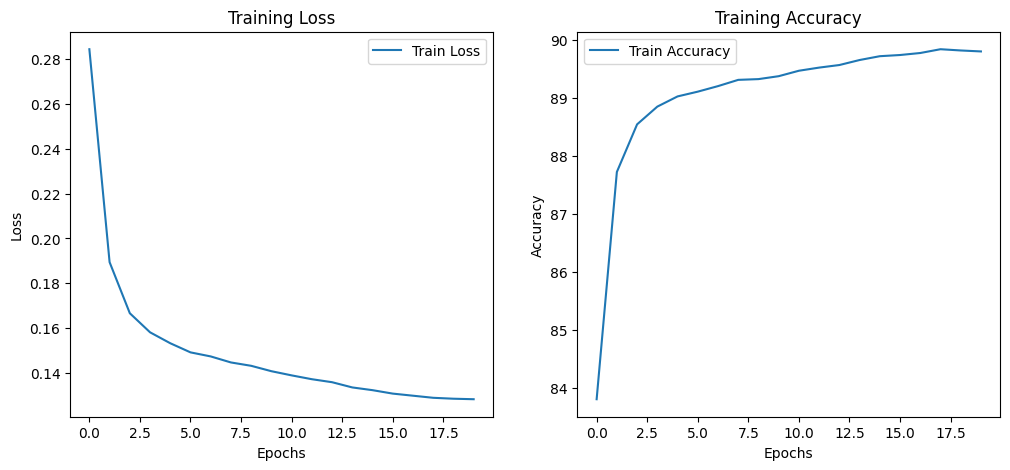

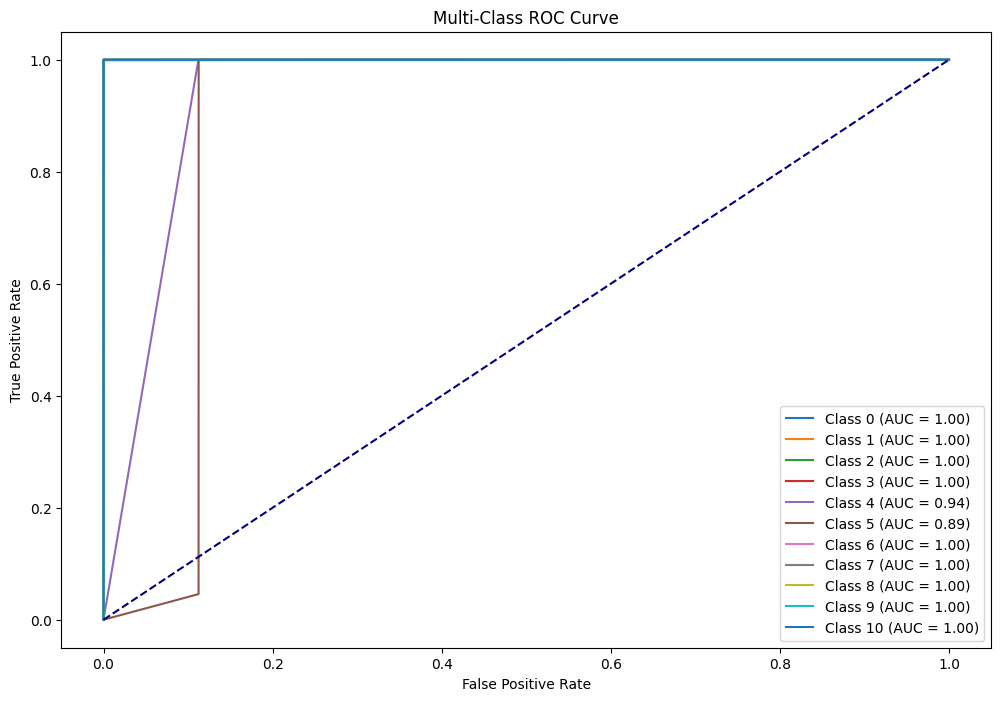

In [ ]:

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Prepare the dataset
image_dataset_tensor = torch.tensor(image_dataset, dtype=torch.float32).permute(0, 3, 1, 2)
image_labels_tensor = torch.tensor(image_labels, dtype=torch.long)

# Compute class weights for imbalance handling
class_counts = torch.bincount(image_labels_tensor)
class_weights = 1.0 / class_counts
weights = class_weights.to(device)

# Dataset splitting
dataset = TensorDataset(image_dataset_tensor, image_labels_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define an improved CNN architecture for multi-class classification
class ImprovedMultiClassCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedMultiClassCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(64, 128)
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Instantiate the model, loss function, optimizer, and scheduler
num_classes = len(torch.unique(image_labels_tensor))
model = ImprovedMultiClassCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

# Function to count and print the number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print model architecture
print(model)
print(f"Number of trainable parameters: {count_parameters(model)}")

# Early Stopping class
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Train the model with a progress bar and learning rate scheduling
def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=20):
    train_losses = []
    train_accuracies = []

    for epoch in tqdm(range(num_epochs), desc="Training Epochs"):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Update learning rate and check for early stopping
        scheduler.step()
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    return train_losses, train_accuracies

# Evaluate the model and generate confusion matrix
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100. * correct / total
    test_loss = test_loss / len(test_loader)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

    # Precision, Recall, F1-Score
    report = classification_report(all_labels, all_preds, target_names=[str(i) for i in range(num_classes)])
    print(report)

    return test_loss, accuracy

# ROC and AUC curves for multi-class classification
def plot_multi_class_roc(model, test_loader, num_classes):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = nn.functional.softmax(outputs, dim=1)
            all_preds.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Binarize the labels for multi-class ROC curve calculation
    all_labels_binarized = label_binarize(all_labels, classes=list(range(num_classes)))

    plt.figure(figsize=(12, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(all_labels_binarized[:, i], all_preds[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Train the model
num_epochs = 20
train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs)

# Evaluate the model
test_loss, test_accuracy = evaluate_model(model, test_loader)

# Plot accuracy and loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Plot ROC-AUC curves
plot_multi_class_roc(model, test_loader, num_classes)
